In [2]:
import os
import charts_function_list

In [3]:
base,data,outputs = charts_function_list.folder_setup()
os.chdir(data)

### Version 1 looks at IRS county flow. 

While more accurate at the individual level, it is based on tax returns and more difficult to determine full people

In [29]:
inflow = pd.read_csv('countyinflow1516.csv')
outflow = pd.read_csv('countyoutflow1516.csv')

#rename some columns to make them more informative
inflow = inflow.rename(columns={'y2_statefips':'Destination State FIPS','y2_countyfips':'Destination County FIPS',
                      'y1_statefips':'Origin State FIPS','y1_countyfips':'Origin County FIPS',
                      'y1_state':'Origin State','y1_countyname':'Origin County',
                      'n1':'Number of Returns','n2':'Number of Exemptions','agi':'Adjusted Gross Income'})

outflow = outflow.rename(columns={ 'y1_statefips':'Origin State FIPS','y1_countyfips':'Origin County FIPS',
                                  'y2_statefips':'Destination State FIPS','y2_countyfips':'Destination County FIPS',
                                  'y2_state':'Destination State','y2_countyname':'Destination County',
                      'n1':'Number of Returns','n2':'Number of Exemptions','agi':'Adjusted Gross Income'})


la_county_in = inflow[(inflow['Destination County FIPS']==37)&(inflow['Destination State FIPS']==6)]
la_county_in = la_county[(~la_county['Origin State FIPS'].isin([96,97,98,57,59]))&(la_county['Origin County']!='Los Angeles County Non-migrants')]

la_county_out = outflow[(outflow['Origin County FIPS']==37)&(outflow['Origin State FIPS']==6)]
la_county_out = la_county_out[(~la_county_out['Destination State FIPS'].isin([96,97,98,57,59]))&(la_county_out['Destination County']!='Los Angeles County Non-migrants')]

la_county_out= la_county_out[['Destination State FIPS',
       'Destination County FIPS', 'Destination State', 'Destination County',
       'Number of Returns', 'Number of Exemptions', 'Adjusted Gross Income']].rename(columns={'Destination State FIPS':'State FIPS',
                                                                                             'Destination County FIPS':'County FIPS',
                                                                                             'Destination State':'State',
                                                                                             'Destination County':'County'})

la_county_out['Flow Direction'] = 'Out'




la_county_in = la_county_in[['Origin State FIPS','Origin County FIPS','Origin State','Origin County',
       'Number of Returns', 'Number of Exemptions', 'Adjusted Gross Income']].rename(columns={'Origin State FIPS':'State FIPS',
                                                                                             'Origin County FIPS':'County FIPS',
                                                                                             'Origin State':'State',
                                                                                             'Origin County':'County'})
la_county_in['Flow Direction'] = 'In'



In [114]:
# summary counts
state_count_returns_in = la_county_in.groupby('State').sum()['Number of Returns']
state_count_exmemptions_in = la_county_in.groupby('State').sum()['Number of Exemptions']
state_count_returns_out = la_county_out.groupby('State').sum()['Number of Returns']
state_count_exemptions_out = la_county_out.groupby('State').sum()['Number of Exemptions']

### Net migration based on Census

Uses 5-year rolling average. Counts the individual but is based on samples.

In [ ]:
#for net migration from Census
CA = pd.read_excel('county-to-county-2012-2016-ins-outs-nets-gross.xlsx',sheet_name='California',)
#multi_columns = CA.loc[0:1].values
#create multi-index for columns
#column_1 = pd.MultiIndex.from_arrays(multi_columns)

#reset columns to multi-index
#CA_.columns = column_1

#drop MOE columns -- the columns with null values for the first level of the index
#CA_ = CA_[column_1[~column_1.get_level_values(0).isnull()]].copy()

CA_ = CA.loc[2:]
new_columns = [str(a)+':'+str(b) for a, b in zip(CA.loc[0].values,CA.loc[1].values)]
CA_.columns = new_columns
CA_ = CA_[CA_.columns[['nan:MOE' not in x for x in CA_.columns]]] #remove the MOE columns
CA_.columns = [x.replace(':nan','') for x in CA_.columns] #replace the "nan" fields
los_angeles_county = CA_[CA_['County Name of Geography A']=='Los Angeles County'].copy()

In [274]:
domestic = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming', 'Puerto Rico']

los_angeles_county['Geography B - Domestic or International'] = np.where(los_angeles_county['State/U.S. Island Area/Foreign Region of Geography B'].isin(domestic),'Domestic','International')
la_domestic = los_angeles_county[los_angeles_county['Geography B - Domestic or International']=='Domestic'].sort_values(by='Net Migration from Geography B to Geography A1:Estimate',ascending=False).copy()

In [275]:
la_county_in_ACS = la_domestic.groupby('State/U.S. Island Area/Foreign Region of Geography B').sum()['Flow from Geography B to Geography A:Estimate']
la_county_out_ACS = la_domestic.groupby('State/U.S. Island Area/Foreign Region of Geography B').sum()[ 'Counterflow from Geography A to Geography B1:Estimate']

In [277]:
state_comparison = pd.merge(pd.DataFrame(la_county_in_ACS),pd.DataFrame(la_county_out_ACS),left_index=True,right_index=True).rename(columns={'Flow from Geography B to Geography A:Estimate':'In-Flow',
                                                                                                              'Counterflow from Geography A to Geography B1:Estimate':'Outflow'})

state_comparison['Net Migration'] = state_comparison['In-Flow']-state_comparison['Outflow']

state_comparison['Los Angeles County'] = 'Los Angeles County'

In [283]:
os.chdir(outputs)
state_comparison.to_csv('state_comparisons.csv')
la_domestic.to_csv('LA_domestic_flow.csv')

In [425]:
no_cal_state = state_comparison[state_comparison.index!='California'].sort_values(by='Net Migration').copy()

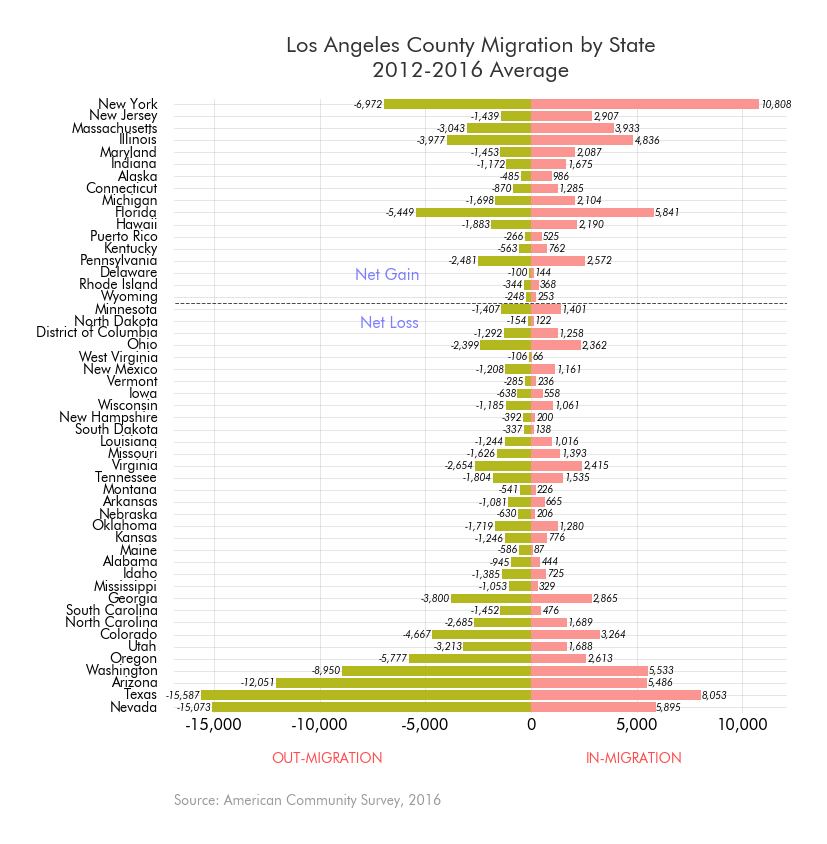

In [463]:
in_migration = charts_function_list.chart_maker(title = 'Los Angeles County Migration by State\n2012-2016 Average',title_size=22)
fig = in_migration.initial_fig_axis(figsize=(11,11))
fig.subplots_adjust(top=.9)
ax = in_migration.axes_set_up(fig=fig)
ax.barh([i for i,v in enumerate(no_cal_state.index)],no_cal_state['In-Flow'],zorder=2,color='#FA9592')
ax.barh([i for i,v in enumerate(no_cal_state.index)],no_cal_state['Outflow']*-1,zorder=2,color='#B2B81D')
ax.tick_params(axis='x',labelsize=16)
ax.tick_params(axis='y',labelsize=14)
yticks = ax.set_yticks([x for x in range(51)])
yticklabels = ax.set_yticklabels(no_cal_state.index,va='center',position=(-.02,0))
xticklabels = ax.set_xticklabels(["{:,}".format(int(x)) for x in ax.get_xticks()])
#ax.vlines(0,ymin=0,ymax=1,transform=ax.get_xaxis_transform(),linewidth=1,alpha=.7,zorder=3)
cutoff = float((no_cal_state.reset_index().loc[no_cal_state.reset_index()['Net Migration']>=0].head(1).index-.5).values)
ax.hlines(cut_off,xmin=-1,xmax=1,transform=ax.get_yaxis_transform(),linewidth=1,alpha=.7,zorder=5,linestyle='--')
for i,v in enumerate(no_cal_state['In-Flow'].values):
    ax.text(v+30,i,str("{:,}".format(v)),va='center',style='italic')
    
for i,v in enumerate((no_cal_state['Outflow']*-1).values):
    ax.text(v-30,i,str("{:,}".format(v)),va='center',style='italic',ha='right')

ax.text(.4,cutoff+2,'Net Gain',ha='right',transform=ax.get_yaxis_transform(),fontsize=16,alpha=.5,color='Blue')
ax.text(.4,cutoff-2,'Net Loss',ha='right',transform=ax.get_yaxis_transform(),fontsize=16,alpha=.5,color='Blue')
    
ax.set_ylim(-.5,50.4)
ax.grid(alpha=.4,zorder=1)
ax.text(.25,-.08,'OUT-MIGRATION',transform=ax.transAxes,ha='center',fontsize=14,color='red',alpha=.7)
ax.text(.75,-.08,'IN-MIGRATION',transform=ax.transAxes,ha='center',fontsize=14,color='red',alpha=.7)
sources = in_migration.citations(ax=ax,source_y=-.15,source='Source: American Community Survey, 2016',chart_tag='')
os.chdir(outputs)
charts_function_list.chart_save('migration_patterns')

In [403]:
no_cal_state['Outflow'].apply(lambda x: "{:,}".format(x))

State/U.S. Island Area/Foreign Region of Geography B
West Virginia              106
Maine                      586
North Dakota               154
South Dakota               337
Delaware                   100
New Hampshire              392
Nebraska                   630
Montana                    541
Vermont                    285
Wyoming                    248
Mississippi              1,053
Rhode Island               344
Alabama                    945
South Carolina           1,452
Puerto Rico                266
Iowa                       638
Arkansas                 1,081
Idaho                    1,385
Kentucky                   563
Kansas                   1,246
Alaska                     485
Louisiana                1,244
Wisconsin                1,185
New Mexico               1,208
District of Columbia     1,292
Oklahoma                 1,719
Connecticut                870
Missouri                 1,626
Minnesota                1,407
Tennessee                1,804
Indiana          

In [395]:
no_cal_state.sort_values(by='In-Flow',ascending=False).head(10)[['In-Flow','Net Migration']]

,In-Flow,Net Migration
State/U.S. Island Area/Foreign Region of Geography B,,
New York,10808,3836
Texas,8053,-7534
Nevada,5895,-9178
Florida,5841,392
Washington,5533,-3417
Arizona,5486,-6565
Illinois,4836,859
Massachusetts,3933,890
Colorado,3264,-1403


In [361]:
for i,v in enumerate(no_cal_state[['Net Migration','In-Flow']].values):
    print(v)

[-40  66]
[-499   87]
[-32 122]
[-199  138]
[ 44 144]
[-192  200]
[-424  206]
[-315  226]
[-49 236]
[  5 253]
[-724  329]
[ 24 368]
[-501  444]
[-976  476]
[259 525]
[-80 558]
[-416  665]
[-660  725]
[199 762]
[-470  776]
[501 986]
[-228 1016]
[-124 1061]
[ -47 1161]
[ -34 1258]
[-439 1280]
[ 415 1285]
[-233 1393]
[  -6 1401]
[-269 1535]
[ 503 1675]
[-1525  1688]
[-996 1689]
[ 634 2087]
[ 406 2104]
[ 307 2190]
[ -37 2362]
[-239 2415]
[  91 2572]
[-3164  2613]
[-935 2865]
[1468 2907]
[-1403  3264]
[ 890 3933]
[ 859 4836]
[-6565  5486]
[-3417  5533]
[ 392 5841]
[-9178  5895]
[-7534  8053]
[ 3836 10808]
